<a href="https://colab.research.google.com/github/Audeon/paintergan/blob/main/Kaggle_Im_Something_of_a_Painter_Myself.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Kaggle Competition Work - Im Something of a Painter Myself

**Team**: Acolytes of the Basilisk

**Team Members**: 
*   the protagonist
*   Michael Whitford

**The Challenge**:

A GAN consists of at least two neural networks: a generator model and a discriminator model. The generator is a neural network that creates the images. For our competition, you should generate images in the style of Monet. This generator is trained using a discriminator.

The two models will work against each other, with the generator trying to trick the discriminator, and the discriminator trying to accurately classify the real vs. generated images.

Your task is to build a GAN that generates 7,000 to 10,000 Monet-style images. 

# Pip Installs and Data Download
Install all the pip requirements, and next work on Data downloading options. 

In [1]:
!pip install -qq kaggle 

In [ ]:
!pip install -qq tensorflow_addons

# Kaggle API Downloads
This part allows you to copy your kaggle config files from google drive and use it to download the kaggle competition data.

In [4]:
%env KAGGLE_CONFIG_DIR = /content/

env: KAGGLE_CONFIG_DIR=/content/


In [20]:
! kaggle competitions download -c gan-getting-started -p /content/data/

User cancelled operation


In [1]:
!cp /content/drive/MyDrive/"Colab Notebooks"/config/kaggle.json /content/

# Copy Dataset from Google Drive
This will copy the zip file from the google drive and unzip it into the useful dir. 

In [3]:
!mkdir /content/data/

In [4]:
!cp /content/drive/MyDrive/"Colab Notebooks"/data/gan-getting-started.zip /content/data/

In [ ]:
!unzip /content/data/gan-getting-started.zip -d /content/data/

# Python Package Imports and TPU Setup.

In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import numpy as np

This section will check and see if we have TPUs that we can do the processing on. TPUs are faster than GPUs and MANY times faster than CPUs. Luckily colab has TPUs.

**TODO: Must add cloud file system for TPU usage. Running with TPU atm breaks the file loading. Will sort out later, for now run GPU.**




In [7]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE

Number of replicas: 1


In [8]:
tf.__version__

'2.8.0'

# Load the TFRecord

In [9]:
data_path = "/content/data/" 

In [10]:
monet_filenames = tf.io.gfile.glob(str(data_path + 'monet_tfrec/*.tfrec'))
photo_filenames = tf.io.gfile.glob(str(data_path + 'photo_tfrec/*.tfrec'))

In [11]:
print(f"Monet TFRecord Files: {len(monet_filenames)}")
print(f"Photo TFRecord Files: {len(photo_filenames)}")

Monet TFRecord Files: 5
Photo TFRecord Files: 20


In [12]:
print(f"File Paths: { monet_filenames }")

File Paths: ['/content/data/monet_tfrec/monet00-60.tfrec', '/content/data/monet_tfrec/monet04-60.tfrec', '/content/data/monet_tfrec/monet16-60.tfrec', '/content/data/monet_tfrec/monet12-60.tfrec', '/content/data/monet_tfrec/monet08-60.tfrec']


# Read and Decode Image Data from TFRecord
Next we will read the TFRecord and export the image data, using the decode image function we will also define here. 

In [13]:
image_size = [256,256] #@param

This decodes the image data from the TFRecord, casts the data to a new tensor.

In [14]:
def decode_image(image):
  image = tf.image.decode_jpeg(image, channels=3)
  image = (tf.cast(image, tf.float32)/ 127.5) - 1
  image = tf.reshape(image, [*image_size, 3])
  return image

In [15]:
def read_tfrecord(example):
  tfrecord_format = {
      "image_name": tf.io.FixedLenFeature([], tf.string),
      "image": tf.io.FixedLenFeature([], tf.string),
      "target": tf.io.FixedLenFeature([], tf.string)
  }

  example = tf.io.parse_single_example(example, tfrecord_format)
  image = decode_image(example['image'])
  return image


Define the function to extract the image from the files

In [16]:
def load_dataset(filenames, labeled=True, ordered=False):
  dataset = tf.data.TFRecordDataset(filenames)
  dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
  return dataset

Now we can start to load in the datasets.

In [17]:
monet_ds = load_dataset(monet_filenames, labeled=True).batch(1)
photo_ds = load_dataset(photo_filenames, labeled=True).batch(1)

In [18]:
example_monet = next(iter(monet_ds))
example_photo = next(iter(photo_ds))

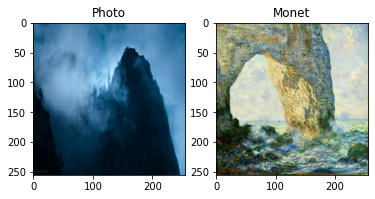

In [19]:
plt.subplot(121)
plt.title("Photo")
plt.imshow(example_photo[0]*0.5 + 0.5)
plt.subplot(122)
plt.title("Monet")
plt.imshow(example_monet[0]*0.5 + 0.5)

# Up/Down Samplers

In [21]:
output_channels = 3

In [78]:
def downsample(filters, size, apply_instancenorm=True):
  initializer = tf.random_normal_initializer(0., 0.02, 42)
  gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
  result = keras.Sequential()
  result.add(
      layers.Conv2D(filters, size, strides=2, padding='same', 
      kernel_initializer=initializer, use_bias=False)
      )
  
  if apply_instancenorm:
    result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

  result.add(layers.Activation("swish"))
  #result.add(layers.LeakyReLU())
  return result


In [77]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02, 42)
  gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

  result = keras.Sequential()
  result.add(
      layers.Conv2DTranspose(filters, size, strides=2,
                             padding='same', kernel_initializer=initializer, use_bias=False)
  )
  result.add(
      tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)
  )
  if apply_dropout:
    result.add(layers.Dropout(0.5))

  result.add(layers.Activation("swish"))
  #result.add(layers.ReLU())
  return result

# Generator Construction

In [79]:
def Generator():
  inputs = layers.Input(shape=[256,256,3])

  down_stack = [
                downsample(64,4, apply_instancenorm=False),
                downsample(128, 4),
                downsample(512, 4),
                downsample(512,4),
                downsample(512,4),
                downsample(512,4),
                downsample(512,4),
  ]

  up_stack = [
              upsample(512, 4, apply_dropout=True),
              upsample(512, 4, apply_dropout=True),
              upsample(512, 4, apply_dropout=True),
              upsample(512, 4),
              upsample(256, 4),
              upsample(128, 4),
              upsample(64, 4),
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = layers.Conv2DTranspose(output_channels, 4, strides=2, padding='same', 
                                kernel_initializer=initializer, activation='tanh')
  x = inputs

  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)
  
  skips = reversed(skips[:-1])

  for up, skip, in zip(up_stack, skips):
    x = up(x)
    x = layers.Concatenate()([x, skip])

  x = last(x)
  
  return keras.Model(inputs=inputs, outputs=x)

# Discriminator Construction
The disciminator takes in images and classifies them as real or fake. 

In [80]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)
  gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02, seed=42)
  inp = layers.Input(shape=[256, 256, 3], name='input_image')
  x=inp

  down1 = downsample(64,4, False)(x)
  down2 = downsample(128,4)(down1)
  down3 = downsample(256,4)(down2)

  zero_pad1 = layers.ZeroPadding2D()(down3)
  conv = layers.Conv2D(512, 4, strides=1, kernel_initializer=initializer, use_bias=False)(zero_pad1)

  norm1 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(conv)

  leaky_relu = layers.LeakyReLU()(norm1)
  zero_pad2 = layers.ZeroPadding2D()(leaky_relu)

  last = layers.Conv2D(1,4, strides=1, kernel_initializer=initializer)(zero_pad2)

  return tf.keras.Model(inputs=inp, outputs=last)

In [81]:
with strategy.scope():
  monet_generator = Generator() # Transforms photos into Money like paintings
  photo_generator = Generator() # Transforms monets to be more like photos.

  monet_discriminator = Discriminator() # Checks if  real monet or fake
  photo_discriminator = Discriminator() # Checks if photo is real or fake

In [38]:
to_monet = monet_generator(example_photo)

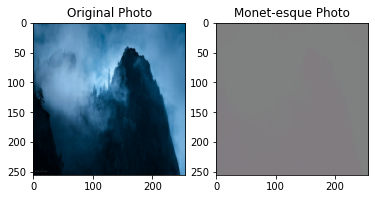

In [82]:


plt.subplot(1, 2, 1)
plt.title("Original Photo")
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(1, 2, 2)
plt.title("Monet-esque Photo")
plt.imshow(to_monet[0] * 0.5 + 0.5)
plt.show()

# Build the CycleGAN model

In [83]:
class CycleGan(keras.Model):
  def __init__(self, monet_generator, photo_generator,monet_discriminator, photo_discriminator, lambda_cycle=10):
    super(CycleGan, self).__init__()
    self.m_gen = monet_generator
    self.p_gen = photo_generator
    self.m_disc = monet_discriminator
    self.p_disc = photo_discriminator
    self.lambda_cycle = lambda_cycle
  
  def compile(self, m_gen_optimizer, p_gen_optimizer, m_disc_optimizer, 
              p_disc_optimizer, gen_loss_fn, disc_loss_fn, cycle_loss_fn, 
              identity_loss_fn):
    super(CycleGan, self).compile()
    self.m_gen_optimizer = m_gen_optimizer
    self.p_gen_optimizer = p_gen_optimizer
    self.m_disc_optimizer = m_disc_optimizer
    self.p_disc_optimizer = p_disc_optimizer
    self.gen_loss_fn = gen_loss_fn
    self.disc_loss_fn = disc_loss_fn
    self.cycle_loss_fn = cycle_loss_fn
    self.identity_loss_fn = identity_loss_fn

  def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

# Define Loss Function

In [84]:
with strategy.scope():
    def discriminator_loss(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)

        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)

        total_disc_loss = real_loss + generated_loss

        return total_disc_loss * 0.5

In [85]:
with strategy.scope():
    def generator_loss(generated):
        return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

In [86]:
with strategy.scope():
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

        return LAMBDA * loss1

In [87]:
with strategy.scope():
    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss

# Train CycleGAN

In [88]:
with strategy.scope():
    monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [89]:
with strategy.scope():
    cycle_gan_model = CycleGan(
        monet_generator, photo_generator, monet_discriminator, photo_discriminator
    )

    cycle_gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

# Initialize Training Cycle

In [91]:
cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=25
)

Epoch 1/25
300/300 [==============================] - 90s 300ms/step - monet_gen_loss: 3.4752 - photo_gen_loss: 3.5321 - monet_disc_loss: 0.6766 - photo_disc_loss: 0.6617
Epoch 2/25
300/300 [==============================] - 90s 300ms/step - monet_gen_loss: 3.3175 - photo_gen_loss: 3.4083 - monet_disc_loss: 0.6637 - photo_disc_loss: 0.6490
Epoch 3/25
300/300 [==============================] - 90s 300ms/step - monet_gen_loss: 3.2638 - photo_gen_loss: 3.2990 - monet_disc_loss: 0.6412 - photo_disc_loss: 0.6428
Epoch 4/25
300/300 [==============================] - 90s 299ms/step - monet_gen_loss: 3.2001 - photo_gen_loss: 3.2102 - monet_disc_loss: 0.6313 - photo_disc_loss: 0.6365
Epoch 5/25
300/300 [==============================] - 90s 300ms/step - monet_gen_loss: 3.1334 - photo_gen_loss: 3.1397 - monet_disc_loss: 0.6278 - photo_disc_loss: 0.6331
Epoch 6/25
300/300 [==============================] - 90s 299ms/step - monet_gen_loss: 3.0840 - photo_gen_loss: 3.0972 - monet_disc_loss: 0.6263 

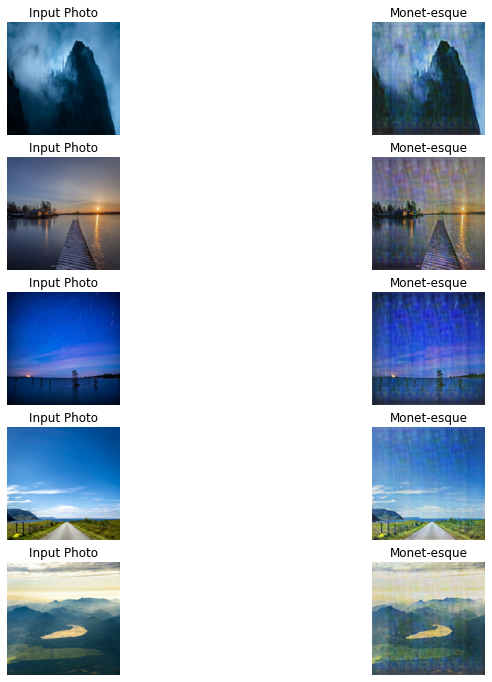

In [92]:
_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i, img in enumerate(photo_ds.take(5)):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()